# Industrial case analysis: steel production

## Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

In [3]:
from joblib import Parallel, delayed # ! pip install joblib
from IPython.display import Image
from scipy import optimize

In [4]:
# research reproducibility
SEED = 42

## Technological process description

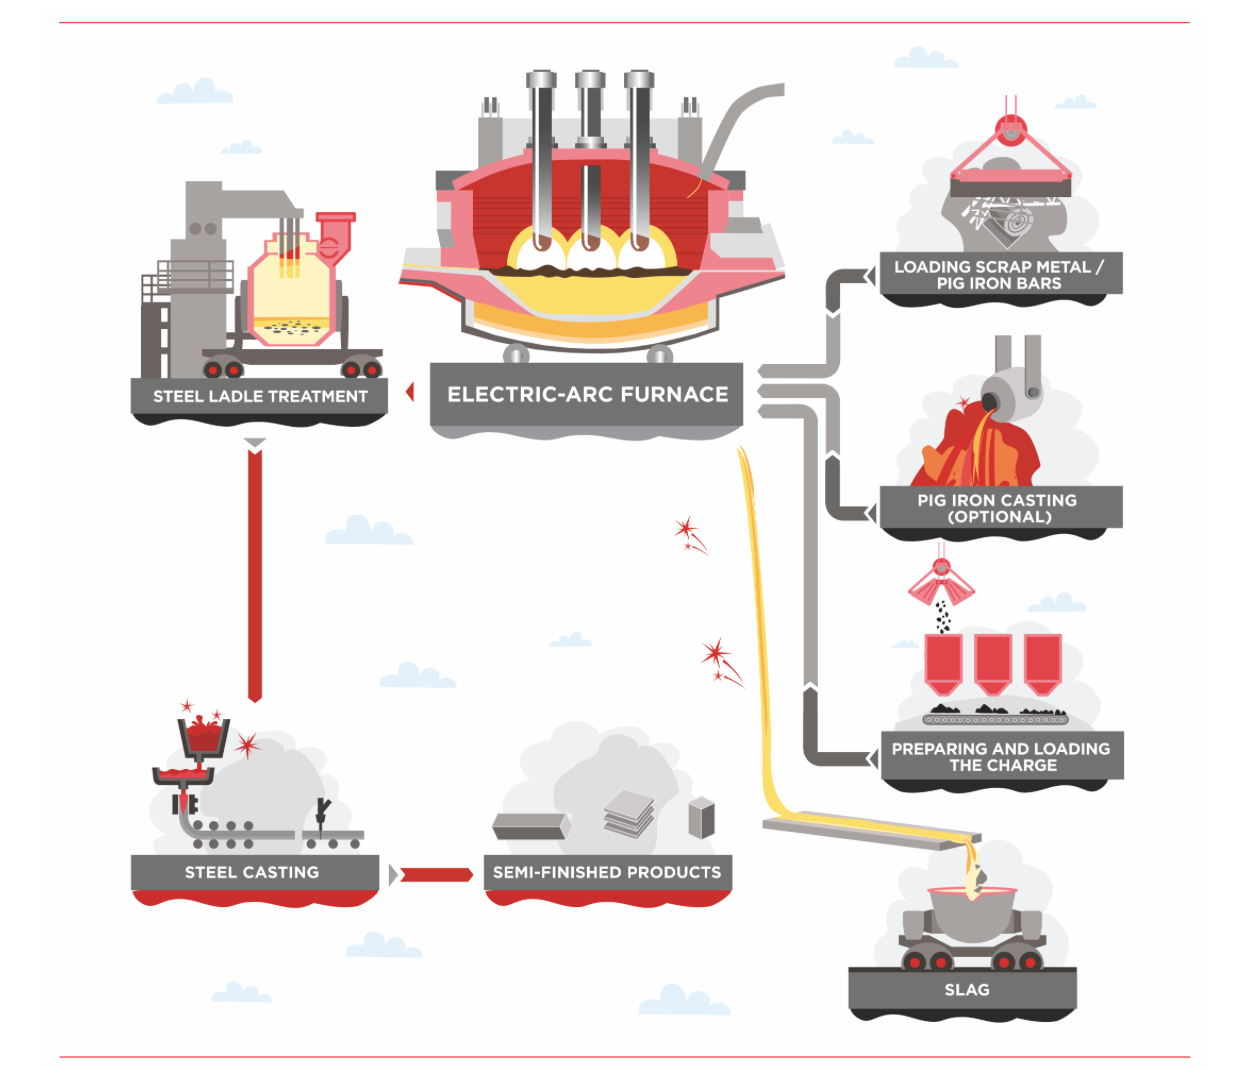

In [5]:
Image(filename = 'electric-arc-furnances.png') 

Since the second half of the XX century, an ever-increasing amount of steel has been produced using electric-arc furnaces. This production method requires a lot of electricity. That is why it has only been developed in the countries that can afford it, including the US, India and China. Today, electric steel accounts for about a third of overall global production. Most of this steel is smelted in electric-arc furnaces.

An electric-arc furnace consists of an iron upper shell with a spherical bottom. The inside of the upper shell is lined with refractory bricks. The furnace proper, where the smelting occurs, has a rotating cover. The device resembles a huge crockpot. 

To cook a dish, the "pot" is filled with the charge, scrap metal and the remaining ingredients needed to make a particular grade of steel. It is seasoned with limestone. After the ingredients have been loaded into the pot, the lid is closed, the electrodes are lowered and the electrical current is switched on. The pot's contents are heated to 1,500° C and become even hotter once the electrodes get to work. However, the energy comes not from the electrodes themselves, but rather from the arc that occurs between them and the metal charge that has been loaded into the furnace. Steelmakers got the idea by observing a natural phenomenon: lightning. An electric charge is carried from the electrodes to the liquid metal just like lightning surges to the ground from the clouds. 

Once the smelting is complete, steel and slag remain in the furnace. The slag absorbs any unnecessary impurities and floats to the top. The purpose of the process is to obtain a semi-finished product with the necessary chemical composition. 

Steel founders have a secret that lets them check the steel's quality while it is still inside the vessel. They take samples of the slag. Performing a chemical analysis of the slag helps to determine whether the steel is ready for use. 

To control the smelting process, the furnace has an observation hole, a steel tap hole and a slag tap hole. 

Electric-arc furnaces come in various capacities ranging from 0.5 tonnes to 400 tonnes. The smelting time is only 40-55 minutes, which makes it possible to do up to 40 smeltings a day. Electric-arc furnaces can produce high-quality steel. This method is used for smelting high-alloyed, structural and specialty steels, as well as alloys

## 1. Data

During this project we will work with two sections of steel production:
* EAF (Electric-arc furnance) 
* LF (Ladle furnance)
* CCM (Continious Casting System) 

You can learn more about steelmaking and the operation of these furnaces [here](http://metinvest.tilda.ws/ensteelmaking).

### 1.1. Data loading

In [6]:
# we have data for 2017 year

df17 = {}

In [7]:
# we collect and read data related to EAF and LF from .sav files (.sav comes from SPSS systems)
for sheet_name in ['EAF4', 'EAF5',
                   'LF3', 'LF4',
                   'CCM4', 'CCM5',
                   'EAF4_LAST_ANALYSIS', 'EAF5_LAST_ANALYSIS',
                   'LF3_LAST_ANALYSIS', 'LF4_LAST_ANALYSIS']:
    df17[sheet_name] = pd.read_pickle(f'../data/data_2017_{sheet_name}.sav')
    print(f'{sheet_name}\tdata shape:\t{df17[sheet_name].shape}')

EAF4	data shape:	(3594, 49)
EAF5	data shape:	(5829, 51)
LF3	data shape:	(4089, 40)
LF4	data shape:	(6390, 40)
CCM4	data shape:	(4351, 26)
CCM5	data shape:	(5038, 26)
EAF4_LAST_ANALYSIS	data shape:	(3288, 22)
EAF5_LAST_ANALYSIS	data shape:	(4880, 22)
LF3_LAST_ANALYSIS	data shape:	(3674, 22)
LF4_LAST_ANALYSIS	data shape:	(5741, 22)


Thus, we have:
* two electric-arc furnances (`EAF4` и `EAF5`)
* two ladle furnances (`LF4` и `LF5`)
* two continious casting cystems (`CCM4` и `CCM5`)

## 1.2. Data schema review

In [8]:
# differences between EAF4 and EAF5 
list(set(df17['EAF4'].columns) - set(df17['EAF5'].columns))

[]

In [9]:
# differences between EAF4 and EAF5 
list(set(df17['EAF5'].columns) - set(df17['EAF4'].columns))

['Hot Dri Temp', 'Ladle ID']

In [10]:
# differences between LF3 and LF4

list((set(df17['LF3'].columns) - set(df17['LF4'].columns))) + \
list((set(df17['LF4'].columns) - set(df17['LF3'].columns)))

[]

In the remaining data sourcea there are no problems with the list of variables. However, it is recommended to verify this.

## 1.3. Data sources join

For further work it is necessary to collect similar data into one dataset (dataframe). 
Let's consider typical problems in the name of columns.

In [11]:
# First, let's see how column names looks like

list(df17['EAF4'].columns)[:15]

['Heat Id',
 'Plant No.',
 'Date',
 'Steel Grade',
 'Start',
 'Stop',
 'Bkt. DRI',
 'Pig Iron',
 'HBI',
 'Scrap',
 'Cold DRI',
 'HOT\nDRI',
 'EAF \nFerro Alloys',
 'Pour\nback',
 'Tot.\nCharged Wt']

In [12]:
# Helper function to normalize feature names

def rename_col(x):
    """Makes col namings normalisation"""
    return (x.strip() 
            .replace('\n', ' ') 
            .replace(' ', '_')
            .replace('.', '') 
            .replace('__', '_') 
            .lower()) 

In [13]:
# Check names
list(map(rename_col, df17['EAF4'].columns))[:15]

['heat_id',
 'plant_no',
 'date',
 'steel_grade',
 'start',
 'stop',
 'bkt_dri',
 'pig_iron',
 'hbi',
 'scrap',
 'cold_dri',
 'hot_dri',
 'eaf_ferro_alloys',
 'pour_back',
 'tot_charged_wt']

In [14]:
# united dataset for EAF
df_eaf = (df17['EAF4']
          .append(df17['EAF5'])
          .rename(columns = rename_col) # apply our function
          .reset_index(drop = True))

# change manually the types for some variables 
df_eaf['plant_no'] = df_eaf['plant_no'].astype(str) # id plant
df_eaf.rename(columns={'plant_no': 'plant'}, inplace = True)
df_eaf['heat_id'] = df_eaf['heat_id'].astype(int) # id of smelting
df_eaf = df_eaf[df_eaf['steel_grade'] != ' '] # remove unknown (unspecified) steel grades
df_eaf['steel_grade'] = df_eaf['steel_grade'].astype(int) # steel grade

df_eaf.head(3)

,heat_id,plant,date,steel_grade,start,stop,bkt_dri,pig_iron,hbi,scrap,...,femnhc,femnlc,al,fecrlc,femo,simn,carbag,mangan,ladle_id,hot_dri_temp
0,1701015,EAF4,2017-01-01,112,2016-12-31 23:24:17,2017-01-01 00:20:50,0,0,0,35.1,...,391.0,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1701016,EAF4,2017-01-01,112,2017-01-01 00:28:19,2017-01-01 01:39:36,0,0,0,35.5,...,390.0,NaN,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1701017,EAF4,2017-01-01,112,2017-01-01 01:49:53,2017-01-01 02:46:25,0,0,0,38.6,...,390.0,NaN,294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# united dataframe for LF
df_lf = (df17['LF3']
         .append(df17['LF4'])
         .rename(columns = rename_col)
         .reset_index(drop = True))

# change manually the types for some variables 
df_lf['plant_no'] = df_lf['plant_no'].astype(str) # # id plant
df_lf.rename(columns = {'plant_no': 'plant'}, inplace = True)

df_lf.head(3)

,heat_id,plant,treatment,date,steel_grade,start,stop,treatment_time,pon,first_o2,...,fecrlc,femo,simn,casiwire,alwire,fev,fet,fenb,carbag,mangan
0,1701015,LF3,1,2017-01-01,112,2017-01-01 00:39:22,2017-01-01 01:13:25,34.98,4.0,81.9,...,NaN,NaN,NaN,NaN,74.250,NaN,NaN,NaN,NaN,NaN
1,1701016,LF3,1,2017-01-01,112,2017-01-01 02:16:10,2017-01-01 02:54:00,38.73,8.0,12.4,...,NaN,NaN,NaN,NaN,95.733,NaN,NaN,NaN,NaN,NaN
2,1701017,LF3,1,2017-01-01,112,2017-01-01 03:16:27,2017-01-01 03:55:48,40.13,12.0,3.3,...,NaN,NaN,NaN,NaN,85.833,NaN,NaN,NaN,NaN,NaN


In [16]:
# united frame CCM
df_ccm = (df17['CCM4']
          .append(df17['CCM5'])
          .rename(columns=rename_col)
          .reset_index(drop=True))

# change manually the types for some variables 
df_ccm = df_ccm[df_ccm['heat_id'] != 'S00019'] # eror measurement, can be deleted manually, without procedure
df_ccm['heat_id'] = df_ccm['heat_id'].astype(int) # id heat

df_ccm.head(3)

,heat_id,plant_no,date,steel_grade,ladle_open,ladle_close,ladle_start_weight,ladle_end_weight,slabweight,slab_number,...,tail_crop_loss,total_sampling_lose,ladle_id,powder_kind,powder_amount,powder_kind2,powder_amount3,slab_weight,powder_kind1,powder_amount1
0,1701015,CC4,2017-01-01,112,2017-01-01 01:24:41,2017-01-01 02:15:21,151.272,0.00,163.3892,8,...,0.0,0.0,16,Nermat AF,0,Nermat AF,0.0,NaN,NaN,NaN
1,1701016,CC4,2017-01-01,112,2017-01-01 03:10:51,2017-01-01 04:07:10,153.451,0.00,160.8189,9,...,0.0,0.0,5,Nermat AF,0,Nermat AF,0.0,NaN,NaN,NaN
2,1701017,CC4,2017-01-01,112,2017-01-01 04:10:17,2017-01-01 05:04:15,152.317,3.67,144.5911,8,...,0.0,0.0,11,Nermat AF,0,Nermat AF,0.0,NaN,NaN,NaN


In [17]:
# United dataframe for EAF labaratory analysis
df_eaf_res = (df17['EAF4_LAST_ANALYSIS']
              .append(df17['EAF5_LAST_ANALYSIS'])
              .rename(columns = rename_col)
              .reset_index(drop = True))

# replacement of faulty mappings
df_eaf_res['plant'] = df_eaf_res['plant'].astype(str)
df_eaf_res['plant'] = df_eaf_res['plant'].replace({'EAF1': 'EAF4', 'EAF2': 'EAF5'})

df_eaf_res.head(3)

,heat_id,steel_grade,sample_date,plant,carbon,silicon,manganese,vanadium,nitrogen,sulphur,...,chromium,molybdenum,nickel,copper,titanium,niobium,lead,boron,tungsten,calcium
0,1701012,112.0,2016-12-31 20:53:05,EAF4,0.0734,0.007,0.320,0.00168,0.0026,0.0093,...,0.0157,0.00613,0.0181,0.0507,0.00096,0.0,0.0003,0.00019,0.0002,0.00042
1,1701014,112.0,2016-12-31 23:09:36,EAF4,0.0675,0.008,0.321,0.00154,0.0025,0.0080,...,0.0184,0.00590,0.0187,0.0385,0.00097,0.0,0.0001,0.00018,0.0000,0.00042
2,1701015,112.0,2017-01-01 00:20:50,EAF4,0.0601,0.009,0.336,0.00195,0.0026,0.0071,...,0.0198,0.00455,0.0221,0.0296,0.00109,0.0,0.0003,0.00018,0.0000,0.00045


In [18]:
# United dataframe for LF labaratory analysis
df_lf_res = (df17['LF3_LAST_ANALYSIS']
             .append(df17['LF4_LAST_ANALYSIS'])
             .rename(columns = rename_col)
             .reset_index(drop = True))

# replacement of faulty mappings
df_lf_res['plant'] = df_lf_res['plant'].astype(str)
df_lf_res['plant'] = df_lf_res['plant'].replace({'LF1': 'LF3', 'LF2': 'LF4'})

df_lf_res.head(3)

,heat_id,steel_grade,sample_date,plant,carbon,silicon,manganese,vanadium,nitrogen,sulphur,...,chromium,molybdenum,nickel,copper,titanium,niobium,lead,boron,tungsten,calcium
0,1701012,112.0,2016-12-31 21:58:44,LF3,0.0734,0.007,0.320,0.00168,0.0026,0.0093,...,0.0157,0.00613,0.0181,0.0507,0.00096,0.0,0.0003,0.00019,0.0002,0.00042
1,1701013,112.0,2016-12-31 23:11:26,LF3,0.0655,0.007,0.330,0.00177,0.0029,0.0108,...,0.0223,0.00587,0.0284,0.0959,0.00090,0.0,0.0003,0.00020,0.0004,0.00040
2,1701014,112.0,2017-01-01 00:20:11,LF3,0.0675,0.008,0.321,0.00154,0.0025,0.0080,...,0.0184,0.00590,0.0187,0.0385,0.00097,0.0,0.0001,0.00018,0.0000,0.00042


## 2. Data preprocessing

Column names:
  - 'heat_id', # - smelting (heat) id
  - 'plant_no', # - plant number
  - 'date', # - smelting (heat) id
  - 'steel_grade', # - steel grade number
  - 'start', [hh:mi] - operation start time
  - 'stop', [hh:mi] - operation stop time
  - 'bkt_dri', [ton] - direct reduction iron
  - 'pig_iron', [ton] - cast iron
  - 'hbi', [ton] - compact direct reduction iron form
  - 'scrap', [ton] - scrap
  - 'cold_dri', [ton] - direct reduction cold iron
  - 'hot_dri', [ton] - direct reduction hot iron
  - 'eaf_ferro_alloys', [ton] - alloying additives
  - 'pour_back', [ton] - refilling (pour back)
  - 'tot_charged_wt', [ton] - total mass at the entrance
  - 'tapped_wt', [ton] - total mass at the end
  - 'yield', % - percentage of mass exit to mass entry
  - 'pon', [mi] - time under current
  - 'tap_to_tap', [mi] - time between arcs
  - 'bottom_stirring', [Nm3] - bottom stirring
  - 'lime', [ton] - lime
  - 'dolo_lime', [ton] - dolomite lime
  - 'lime_inj', [kg] - lime injection
  - 'o2_burner', [Nm3] - о2 burner
  - 'o2_lancing', [Nm3] - о2 purge
  - 'natural_gas', [Nm3] - natural gas purge
  - 'carbon_top_addtion', [kg] - carbon additive
  - 'carbon_injection', [kg] - carbon injection
  - 'first_o2', [PPM] - о2 start concentration
  - 'first_temp', [°C] - start temperature
  - 'last_o2', [PPM] - о2 final concentration 
  - 'last_temp', [°C] - final temperature
  - 'electrical_energy', [kWh] - electrical energy
  - 'avg_power_input', [MW] - avarage power
  - 'power_factor', [%] - power factor
  - 'prim_v', [V] - primary voltage
  - 'ar_stiring_amont', [Nm3] - stiring amount
  - 'emergency_stiring', [Nm3] - emergency stiring
  - 'ladle_id' # , - ladle id
  - 'lf_treatment_end_to_cast_start', [mi] - time from the end of treatment to the beginning of cast 
  - 'n_stiring_amont', [Nm3] - number of stirings
  - 'rinsing_duration', [mi] - rinsing duration
  - 'treatment', # - treatment number
  - 'treatment_time', [mi] - treatment time
  - 'filnelime', [kg] - additive `filnelime`
  - 'anthracite', [kg] - additive `anthracite`
  - 'fluorsap', [kg] - additive `fluorsap`
  - 'synslag', [kg] - additive `synslag`
  - 'fesi', [kg] - additive `fesi`
  - 'femnhc', [kg] - additive `femnhc`
  - 'femnlc', [kg] - additive `femnlc`
  - 'al', [kg] - additive `al`
  - 'fecrlc', [kg] - additive `fecrlc`
  - 'femo', [kg] - additive `femo`
  - 'simn', [kg] - additive `simn`
  - 'carbag', [kg] - additive `carbag`
  - 'mangan', [kg] - additive `mangan`
  - 'alwire', [kg] - additive `alwire`
  - 'caf2', [kg] - additive `caf2`
  - 'casiwire', [kg] - additive `casiwire`
  - 'fenb', [kg] - additive `fenb`
  - 'fet', [kg] - additive `fet`
  - 'fev', [kg] - additive `fev`
  - 'fine_lime', [kg] - additive `fine_lime`
  - 'ladle_start_weight', [ton] - ladle start weight

### 2.1. Data preprocessing - EAF

In [19]:
# smelting system parameters
features_eaf_sys = ['date', 'heat_id', 'ladle_id',
                    'plant', 'start', 'steel_grade', 'stop']

# additives
features_eaf_additions = ['filnelime', 'anthracite', 'fluorsap', 'synslag',
                          'fesi', 'femnhc', 'femnlc', 'al', 'fecrlc', 'femo',
                          'simn', 'carbag', 'mangan']

# smelting results
features_eaf_output = ['tapped_wt', # drained mass, tons
                       'yield'] # yield, %

# energy parameters of the heat
features_eaf_electrical = ['electrical_energy',
                           'avg_power_input', 'power_factor', 'prim_v']

# smelting operating characteristics
features_eaf_operating = ['pon', 'tap_to_tap', 'bottom_stirring',
                          'lime', 'hot_dri_temp', 'dolo_lime', 'lime_inj', 'o2_burner',
                          'o2_lancing', 'natural_gas', 'carbon_top_addtion', 'carbon_injection',
                          'first_o2', 'first_temp', 'last_o2', 'last_temp']

# raw material characteristics
features_eaf_metallic = ['bkt_dri',
                         'pig_iron', 'hbi', 'scrap', 'cold_dri', 'hot_dri',
                         'eaf_ferro_alloys', 'pour_back', 'tot_charged_wt']

# all characteristics
features_eaf_all = (features_eaf_sys
                    + features_eaf_additions
                    + features_eaf_output
                    + features_eaf_electrical
                    + features_eaf_operating
                    + features_eaf_metallic)

In [20]:
# Check that there are no variables left

missed_cols = [col for col in df_eaf.columns if col not in features_eaf_all]
missed_cols

[]

In [21]:
# Note that there is completely zero data, but we will return to this later

df_eaf['synslag'].notnull().sum()

0

In [22]:
# smelting system parameters - from chemical analysis
features_res_sys = ['heat_id', 'steel_grade_analysis', 'sample_date', 'plant']

# component composition of steel - from chemical analysis
features_res_finalcomp = ['carbon', 'silicon',
                          'manganese', 'vanadium', 'nitrogen', 'sulphur', 'phosphorus',
                          'aluminum', 'chromium', 'molybdenum', 'nickel', 'copper', 'titanium',
                          'niobium', 'lead', 'boron', 'tungsten', 'calcium']

#### 2.1.1 Abnormal values - EAF

In [23]:
# Let's check the cases when the yield is more than 100%

_tmp = df_eaf[features_eaf_additions].sum(1)
_tmp = df_eaf.loc[df_eaf['tot_charged_wt'] +
                  df_eaf[features_eaf_additions].sum(1)/1000 < df_eaf['tapped_wt'], 'yield']
_tmp

5485    107.737164
6351    113.782063
6639    112.352192
7404    106.028123
7553    102.496435
8706    103.453996
9297    114.070366
Name: yield, dtype: float64

In [24]:
# One can perform detailed analysis 
# Since there are few of them, we simply delete them without loss of quality

df_eaf = df_eaf.drop(index=_tmp.index)
print("Dropped {}".format(_tmp.size))

Dropped 7


#### 2.1.2. Join with chemical analysis data - EAF

The `df_eaf` data contains all the characteristics of the smelting process. The df_eaf_res data contains the results of chemical analysis of cast steel. To reproduce the full picture of the melting, it is necessary to join two data sources by `heat_id`.

First of all, it is necessary to check that the steel grades match in both sources (a simple check).

In [25]:
# There are cases when steel grade in chemical differ from initial steel grade 

_tmp = df_eaf.merge(df_eaf_res, on = 'heat_id')
_tmp = _tmp[_tmp.steel_grade_x != _tmp.steel_grade_y]

print(f"Cases where df_eaf.steel_grade != df_eaf_res.steel_grade\n{_tmp.shape[0]}")

Cases where df_eaf.steel_grade != df_eaf_res.steel_grade
108


In [26]:
# Let us consider these cases in more detail

_type_swaps = _tmp[['steel_grade_x', 'steel_grade_y']]\
    .groupby(['steel_grade_x', 'steel_grade_y']).size().to_frame('cnt')

_type_swaps

cnt
steel_grade_x steel_grade_y     
110           112.0            3
              3620.0           1
112           200.0            3
              220.0            1
              600.0            1
              900.0            1
              2822.0           1
200           110.0           12
              112.0           14
              220.0            2
              300.0            1
              600.0            3
              610.0            1
              690.0            1
              2400.0           1
              3560.0           1
220           110.0            1
              112.0            2
              200.0            4
300           110.0            3
              200.0            5
              3000.0           1
330           112.0            1
              2822.0           1
352           110.0            5
              112.0            4
              200.0           14
              220.0            1
              300.0            2
              2830.0           3
710           600.0            1
2230          2400.0           2
2400          200.0            1
2822          3000.0           2
2920          112.0            1
2922          200.0            1
3000          200.0            1
3002          110.0            1
3546          3002.0           1
4212          200.0            1

We can see that in most cases the quality of the steel in the chemical results is lower than the planned (from operational data). Thus it is possible that during the smelting, it turned out that the set quality of steel cannot be obtained and a decision to produce a lower grade steel was made

In [27]:
# The number of smeltings with steel grade below than the planned one

sum(_tmp['steel_grade_x'] > _tmp['steel_grade_y'])

76

In [28]:
# Let's check number of smeltings without laboratory analysis
# There are deffects in most cases 
# (engineers began to conduct laboratory analysis - than realized that there is a defect - the results were not logged)

_tmp = df_eaf.merge(df_eaf_res, on = ['heat_id', 'steel_grade'], suffixes = ('', 'analysis'))
_defect = df_eaf.shape[0] - _tmp.shape[0]

print("Number of smeltings without chemical analysis or with changed grade: {:.2%}".format(_defect / df_eaf.shape[0]))

Number of smeltings without chemical analysis or with changed grade: 14.50%


In [29]:
# Chek duplicated index in heat_id

_tmp = df_eaf['heat_id'].value_counts()
(_tmp > 1).sum()

0

In [30]:
# Bind the data for chemical analysis by the smelting id and furnace id.
# Save the data with a mismatching steel grade

df_eaf = df_eaf.merge(df_eaf_res, on = ['heat_id', 'plant'], suffixes = ('', '_analysis'))

In [31]:
# Check that only steel_grade columns are duplicated

[col for col in df_eaf.columns if col.endswith('analysis')]

['steel_grade_analysis']

In [32]:
# Check if each column from new table is associated with a feature

[col for col in df_eaf.columns
 if not (col in features_res_finalcomp or
         col in features_res_sys or
         col in features_eaf_all)]

[]

### 2.2. Data preprocessing - LF

In [33]:
# system parameters
features_lf_sys = ['heat_id', 'plant', 'treatment',
                   'date', 'steel_grade', 'start', 'stop']

# operating parameters
features_lf_operating = ['treatment_time', 'pon', 'first_o2', 'first_temp', 'last_o2', 'last_temp',
                         'rinsing_duration', 'ar_stiring_amont', 'n_stiring_amont', 'emergency_stiring', 'ladle_id']

# energy parameters
features_lf_electrical = ['electrical_energy']

# time parameters
features_lf_timing = ['eaf_tapp_end_to_lf_start',
                      'lf_treatment_end_to_cast_start', 'tapp_end_to_cast_start_(holding_time)']

# additives
features_lf_additions = ['fine_lime', 'anthracite', 'caf2', 'synslag', 'fesi', 'femnhc', 'femnlc',
                         'al', 'fecrlc', 'femo', 'simn', 'casiwire', 'alwire', 'fev', 'fet', 'fenb', 
                         'carbag', 'mangan']

# all variables
features_lf_all = (features_lf_sys
                   + features_lf_operating
                   + features_lf_electrical
                   + features_lf_timing
                   + features_lf_additions)

In [34]:
# Check that there are no variables left

missed_cols = [col for col in df_lf.columns if col not in features_lf_all]
missed_cols

[]

#### 2.2.1. LF data quality check

In [35]:
# Check if there is any duplicates in heat id in treatments?

_tmp = df_lf.loc[df_lf.treatment==1, 'heat_id'].value_counts()
_tmp[_tmp>1].sum()

310

We can see that there is a large number of heats with the same identifier. Let's check the number of such heats.

In [36]:
# How many times is the heat_id index duplicated?

print("number of duplicates: ", _tmp[_tmp>1].unique())

number of duplicates:  [2]


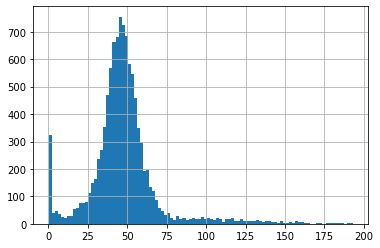

In [37]:
# Treatment time histogram

df_lf[df_lf['treatment_time'] < 200]['treatment_time'].hist(bins=100)
plt.show()

We can see that there is a large number of heats with an extremely low treatment time - perhaps these are data errors or technical errors, let us analyse it.

#### 2.2.1.1. Repeated treatments analysis

In [38]:
# Select the fast treatments (less than a minute)

_tmp_non_longlasting = df_lf[(df_lf['heat_id'].isin(_tmp[_tmp > 1].index))
                             & (df_lf['treatment_time'] < 1)]
_tmp_non_longlasting.heat_id.unique().shape

(39,)

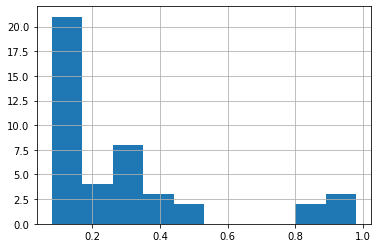

In [39]:
# Fast treatment time distribution

_tmp_non_longlasting.treatment_time.hist()
plt.show()

In [40]:
# Is there any additives usage for such fast treatments?

_tmp_non_longlasting_had_additions = _tmp_non_longlasting[
    _tmp_non_longlasting[features_lf_additions].sum(1) > 0]
_tmp_non_longlasting_had_additions

,heat_id,plant,treatment,date,steel_grade,start,stop,treatment_time,pon,first_o2,...,fecrlc,femo,simn,casiwire,alwire,fev,fet,fenb,carbag,mangan
3818,1749310,LF3,1,2017-12-07,4210,2017-12-07 22:52:42,2017-12-07 22:52:50,0.45,0.0,1055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN


One case can be considered as an outlier

#### 2.2.1.2. Repeated treatments analysis 

In [41]:
# There are duplicate treatments for more than 1 min, but the treatment id is not marked as repeated

_tmp_longlasting = df_lf[(df_lf['heat_id'].isin(_tmp[_tmp > 1].index))
                         & (df_lf['treatment_time'] >= 1)]
_tmp_longlasting.heat_id.unique().shape

(155,)

In [42]:
_tmp_longlasting.sort_values(by = 'heat_id', ascending = True).head()

,heat_id,plant,treatment,date,steel_grade,start,stop,treatment_time,pon,first_o2,...,fecrlc,femo,simn,casiwire,alwire,fev,fet,fenb,carbag,mangan
6,1701021,LF3,1,2017-01-01,112,2017-01-01 08:21:04,2017-01-01 09:02:46,43.30,12.00,732.0,...,NaN,NaN,NaN,NaN,79.200,NaN,NaN,NaN,NaN,NaN
9,1701024,LF3,1,2017-01-02,112,2017-01-02 14:59:00,2017-01-02 16:43:58,105.43,28.00,1073.0,...,NaN,NaN,NaN,NaN,83.622,NaN,NaN,NaN,NaN,NaN
41,1701050,LF3,1,2017-01-04,2922,2017-01-04 10:05:09,2017-01-04 10:47:31,45.03,8.00,21.0,...,NaN,NaN,NaN,NaN,NaN,75.0,49.0,114.0,NaN,NaN
4091,1701050,LF4,1,2017-01-04,2922,2017-01-04 10:53:21,2017-01-04 11:41:35,37.97,7.92,NaN,...,NaN,NaN,NaN,48.84,10.890,NaN,42.0,2.0,NaN,NaN
42,1701051,LF3,1,2017-01-04,200,2017-01-04 17:39:27,2017-01-04 18:14:52,36.45,19.00,0.0,...,NaN,NaN,NaN,NaN,59.433,NaN,NaN,NaN,NaN,NaN


In [43]:
# In what cases are ferroalloys added?

_tmp_longlasting_had_additions = _tmp_longlasting[
    _tmp_longlasting[features_lf_additions].sum(1) > 0]
_tmp_longlasting_had_additions.shape

(252, 40)

In [44]:
_tmp_longlasting_had_additions.head()

,heat_id,plant,treatment,date,steel_grade,start,stop,treatment_time,pon,first_o2,...,fecrlc,femo,simn,casiwire,alwire,fev,fet,fenb,carbag,mangan
6,1701021,LF3,1,2017-01-01,112,2017-01-01 08:21:04,2017-01-01 09:02:46,43.30,12.0,732.0,...,NaN,NaN,NaN,NaN,79.200,NaN,NaN,NaN,NaN,NaN
9,1701024,LF3,1,2017-01-02,112,2017-01-02 14:59:00,2017-01-02 16:43:58,105.43,28.0,1073.0,...,NaN,NaN,NaN,NaN,83.622,NaN,NaN,NaN,NaN,NaN
41,1701050,LF3,1,2017-01-04,2922,2017-01-04 10:05:09,2017-01-04 10:47:31,45.03,8.0,21.0,...,NaN,NaN,NaN,NaN,NaN,75.0,49.0,114.0,NaN,NaN
42,1701051,LF3,1,2017-01-04,200,2017-01-04 17:39:27,2017-01-04 18:14:52,36.45,19.0,0.0,...,NaN,NaN,NaN,NaN,59.433,NaN,NaN,NaN,NaN,NaN
43,1701052,LF3,1,2017-01-04,200,2017-01-04 18:27:59,2017-01-04 19:06:56,39.93,16.0,2.4,...,NaN,NaN,NaN,NaN,82.533,NaN,NaN,NaN,NaN,NaN


#### 2.2.1.3.  Repeted treatment data recovery

For such heats  (where ferroalloys are added) let's fill in the incorrect `treatment` ascending from 1 to the last heat for each ` heat_id`.

In [45]:
# Select indexes for the treatment number recovery

_idx_of_interest = _tmp_non_longlasting_had_additions.heat_id.unique().tolist()
_idx_of_interest += _tmp_longlasting.heat_id.unique().tolist()
len(_idx_of_interest)

156

In [46]:
df_lf.columns

Index(['heat_id', 'plant', 'treatment', 'date', 'steel_grade', 'start', 'stop',
       'treatment_time', 'pon', 'first_o2', 'first_temp', 'last_o2',
       'last_temp', 'rinsing_duration', 'ar_stiring_amont', 'n_stiring_amont',
       'emergency_stiring', 'ladle_id', 'electrical_energy',
       'eaf_tapp_end_to_lf_start', 'lf_treatment_end_to_cast_start',
       'tapp_end_to_cast_start_(holding_time)', 'fine_lime', 'anthracite',
       'caf2', 'synslag', 'fesi', 'femnhc', 'femnlc', 'al', 'fecrlc', 'femo',
       'simn', 'casiwire', 'alwire', 'fev', 'fet', 'fenb', 'carbag', 'mangan'],
      dtype='object')

In [47]:
# Fill in treatments

for _idx in _idx_of_interest:
    _subset = df_lf[df_lf.heat_id == _idx].sort_values('start')
    df_lf.loc[_subset.index, 'treatment'] = np.arange(1, _subset.shape[0] + 1)

#### 2.2.1.4. Repeted treatment statistics

Consider how often treatment is made several times

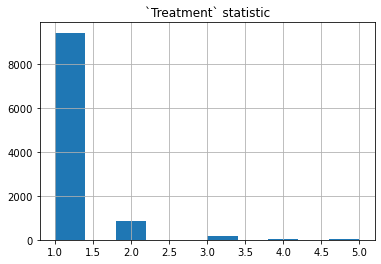

In [48]:
# Repeated treatments

plt.title("`Treatment` statistic")
df_lf.treatment.hist()
plt.show()

In [49]:
_tmp_had_more_than1treatment = df_lf.loc[df_lf.treatment>1, 'heat_id']
_s = _tmp_had_more_than1treatment.shape[0]

print(f"Number of raws with repeated treatment: {_s}")

Number of raws with repeated treatment: 1057


In [50]:
print(f"Number of unique smeltings with several treatments: {_tmp_had_more_than1treatment.unique().size}")

Number of unique smeltings with several treatments: 844


The number of repeated LF treatments for smealting is significantly high. Repeated LF treatments are performed if there is high confidence of failure, or it was decided to change the steel grade during the process.

Since all the features are additive, we can sum them up to have a convenient dataset for work.

In [51]:
# sum up the attributes by fields (heat_id, plant) - summarize repeated treatments

df_lf['treatment'] = 1
df_lf = df_lf.groupby(['heat_id', 'plant']).sum().reset_index()

### 2.2.2. Join with chemical analysis data - LF

In [52]:
# check what variables from LF chemical analysis are not measurements of the components concentration

[col for col in df_lf_res.columns if col not in features_res_finalcomp]

['heat_id', 'steel_grade', 'sample_date', 'plant']

Here again we  check cases where the resulting steel grade (chemical analysis) differs from the innicial one (operational data).

In [53]:
# Number of smealtings with different planned and actual steel grade

_tmp = df_lf.merge(df_lf_res, on=['heat_id', 'plant'])
_tmp = _tmp[_tmp.steel_grade_x != _tmp.steel_grade_y]
_tmp.shape[0]

761

In [54]:
# We consider these cases in more detail, because there are many

_type_swaps = _tmp[['steel_grade_x', 'steel_grade_y']]\
    .groupby(['steel_grade_x', 'steel_grade_y']).size().to_frame('cnt')

_type_swaps

cnt
steel_grade_x steel_grade_y     
120           112.0            1
200           110.0            7
              112.0            9
              220.0            1
220           110.0           29
...                          ...
12630         4210.0           3
12636         4212.0           2
16824         4206.0           2
16832         4208.0           2
18100         3620.0           2

[125 rows x 1 columns]

In [55]:
# Number of smeltings with steel grade below the planned

sum(_tmp['steel_grade_x'] > _tmp['steel_grade_y'])

757

Again, similarly to EAF, in most cases the quality of steel in the results is lower than the planned (in operational data). Thus it is possible that during the smelting, it turned out that the set quality of steel cannot be obtained and a decision to produce a lower grade steel was made

In [56]:
# Let's check number of smeltings without laboratory analysis
# There are defects in most cases 
# (engineers began to conduct laboratory analysis - than realized that there is a defect - the results were not logged)

_tmp = df_lf.merge(df_lf_res, on=['heat_id', 'plant'])
_defect = df_lf.shape[0] - _tmp.shape[0]

print("Number of smeltings without laboratory analysis or with changed steel grade: {:.2%}".format(_defect / df_lf.shape[0]))

Number of smeltings without laboratory analysis or with changed steel grade: 1.80%


In [57]:
# Data merge and filtering out of smeltings without analysis 

_s = df_lf.shape[0]
df_lf = df_lf.merge(df_lf_res, on=['heat_id', 'plant'], suffixes=('', '_analysis'))
print(f'Number of filtered out smeltings: {_s - df_lf.shape[0]}')

Number of filtered out smeltings: 172


In [58]:
# Let's check that only duplicated columns are steel_grade_analysis

[col for col in df_lf.columns if col.endswith('analysis')]

['steel_grade_analysis']

### 2.3. Data preprocessing - CCM

It is possible to recover rrom the CCM the mass of steel entering the ladle furnace- `ladle_start_weight`.

In [59]:
df_lf.shape

(9408, 57)

In [60]:
# Add ladle_start_weight attribute to df_lf using heat_id

df_lf = df_lf.merge(df_ccm[['heat_id','ladle_start_weight']], how='left', on='heat_id')
df_lf.shape

(9409, 58)

In [61]:
# The data have quite good quality, there are few gaps

df_lf.ladle_start_weight.isnull().sum()

32

In [62]:
# We can filter them out

df_lf = df_lf[df_lf.ladle_start_weight.notnull()]
df_lf.shape

(9377, 58)

# 3. Data analysis

## 3.1. Steel grades analysis

In [63]:
# Unique steel grades at EAF stage

steel_grades_eaf = df_eaf['steel_grade'].unique()
steel_grades_eaf.sort()
steel_grades_eaf

array([ 110,  112,  200,  220,  300,  330,  352,  600,  602,  610,  680,
        690,  710,  900,  910, 2110, 2200, 2230, 2400, 2504, 2508, 2610,
       2820, 2822, 2824, 2830, 2910, 2920, 2922, 3000, 3002, 3542, 3544,
       3546, 3560, 3610, 3620, 4110, 4206, 4208, 4210, 4212])

In [64]:
# Unique steel grades at LF stage
steel_grades_lf = df_lf['steel_grade'].unique()
steel_grades_lf.sort()
steel_grades_lf

array([  110,   112,   120,   200,   220,   222,   224,   300,   312,
         320,   330,   336,   352,   400,   440,   462,   464,   512,
         550,   552,   560,   572,   600,   602,   610,   660,   680,
         690,   704,   710,   712,   800,   900,   910,  1000,  1200,
        1204,  1220,  1360,  1380,  1420,  1800,  2110,  2130,  2200,
        2210,  2230,  2240,  2400,  2504,  2508,  2600,  2610,  2730,
        2820,  2822,  2824,  2830,  2910,  2920,  2922,  3000,  3002,
        3100,  3152,  3182,  3300,  3330,  3542,  3544,  3546,  3560,
        3610,  3620,  4110,  4206,  4208,  4210,  4212,  4220,  4400,
        4460,  4800,  5000,  5008,  5016,  5220,  5644,  5648,  5660,
        5744,  5840,  5844,  6000,  6004,  6102,  6324,  6690,  7092,
        7120,  7240,  7512,  7524,  8220,  8412,  8416,  8420,  8424,
        8466,  8490,  8760,  8766,  8822,  8920,  9000,  9006, 10016,
       10860, 11084, 11150, 11288, 11830, 12000, 12008, 12552, 12618,
       12624, 12630,

In [65]:
# Are there any steel grades on EAF that are not found in LF?

[x for x in steel_grades_eaf if x not in steel_grades_lf]

[]

In [66]:
#  Are there any steel grades on LF that are not found in EAF?

len([x for x in steel_grades_lf if x not in steel_grades_eaf])

90

We can see that the amount of steel grades obtained on LF is much higher than on EAF.

### 3.2.  EAF data analysis

#### 3.2.1. General additives statistics

In [67]:
# EAF additives general statistics

df_eaf[features_eaf_additions].describe()

,filnelime,anthracite,fluorsap,synslag,fesi,femnhc,femnlc,al,fecrlc,femo,simn,carbag,mangan
count,8117.000000,457.000000,2582.000000,0.0,1629.000000,7219.000000,998.000000,8035.000000,163.000000,572.000000,1612.000000,336.000000,505.000000
mean,653.301712,214.233260,22.329977,NaN,239.944138,719.080066,566.440882,295.976727,284.693252,280.571678,1389.469603,212.779762,1699.142574
std,106.073631,203.211977,7.447631,NaN,108.264770,642.542802,705.517354,32.690697,126.891970,28.142745,410.581779,106.017708,360.546526
min,7.000000,0.000000,10.000000,NaN,46.000000,12.000000,1.000000,16.000000,26.000000,27.000000,204.000000,4.000000,998.000000
25%,598.000000,41.000000,20.000000,NaN,198.000000,332.000000,300.000000,281.000000,198.000000,250.000000,1007.000000,248.000000,1498.000000
50%,600.000000,52.000000,21.000000,NaN,200.000000,339.000000,303.000000,298.000000,199.000000,285.000000,1108.000000,249.000000,1499.000000
75%,751.000000,452.590000,24.000000,NaN,378.000000,999.000000,500.000000,301.000000,303.000000,300.000000,1808.000000,298.000000,2098.000000
max,2302.000000,482.820000,282.000000,NaN,429.000000,4583.000000,2802.000000,672.000000,504.000000,557.000000,4020.000000,557.000000,4175.000000


In [68]:
# Most common additives

df_eaf[features_eaf_additions].count()

filnelime     8117
anthracite     457
fluorsap      2582
synslag          0
fesi          1629
femnhc        7219
femnlc         998
al            8035
fecrlc         163
femo           572
simn          1612
carbag         336
mangan         505
dtype: int64

The most common additives are `finelime`, `al` and `femnhc`.

In [69]:
# Additives with thw hifhest variance (%)
df_eaf[features_eaf_additions].std() / df_eaf[features_eaf_additions].mean()

filnelime     0.162365
anthracite    0.948555
fluorsap      0.333526
synslag            NaN
fesi          0.451208
femnhc        0.893562
femnlc        1.245527
al            0.110450
fecrlc        0.445715
femo          0.100305
simn          0.295495
carbag        0.498251
mangan        0.212193
dtype: float64

The most variable additives are `femnlc`, `antracite` and `femnhc`.

In [70]:
# total largest additives

df_eaf[features_eaf_additions].sum()

filnelime     5302850.0
anthracite      97904.6
fluorsap        57656.0
synslag             0.0
fesi           390869.0
femnhc        5191039.0
femnlc         565308.0
al            2378173.0
fecrlc          46405.0
femo           160487.0
simn          2239825.0
carbag          71494.0
mangan         858067.0
dtype: float64

`Finelime` and` femnhc` are most the spent, 2 times less (but still a lot) - `al` and` simn`.

In [71]:
# Steel grades frequency

steel_grade_cnt = df_eaf.groupby('steel_grade').count()['heat_id'].sort_values(ascending=False)
steel_grade_pct = (steel_grade_cnt/steel_grade_cnt.sum())

_thr = 0.01
_tmp = steel_grade_cnt[steel_grade_pct>_thr].to_frame()

print(f"Steel grades which appear more that in {_thr*100}% of all smetlings: {_tmp.size}")
_tmp

Steel grades which appear more that in 1.0% of all smetlings: 20


,heat_id
steel_grade,
200,3355
3002,750
112,557
110,517
3000,336
600,256
2230,219
3620,207
2508,166


#### 3.2.2. Analysis of additives for steel grades

In [72]:
# Additive statistics depending of steel grade 

eaf_additions_cnt = df_eaf.groupby('steel_grade')[features_eaf_additions].count()
eaf_additions_mean = df_eaf.groupby('steel_grade')[features_eaf_additions].mean()
eaf_additions_std = df_eaf.groupby('steel_grade')[features_eaf_additions].std()

In [73]:
# We consider only pairs (steel grade - additive) which appear more than 10 times

_filter = eaf_additions_cnt > 10

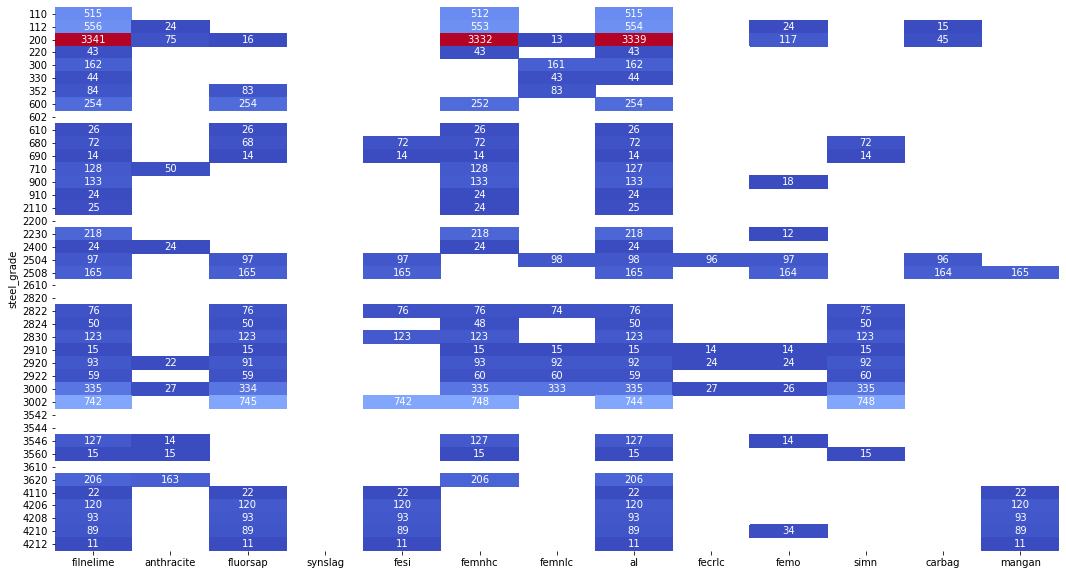

In [74]:
# How many times an additive was added for each steel grade?

plt.figure(figsize=(18, 10))
sns.heatmap(eaf_additions_cnt[_filter],
            cmap = 'coolwarm', annot = True, fmt = 'g', cbar = False)
plt.show()

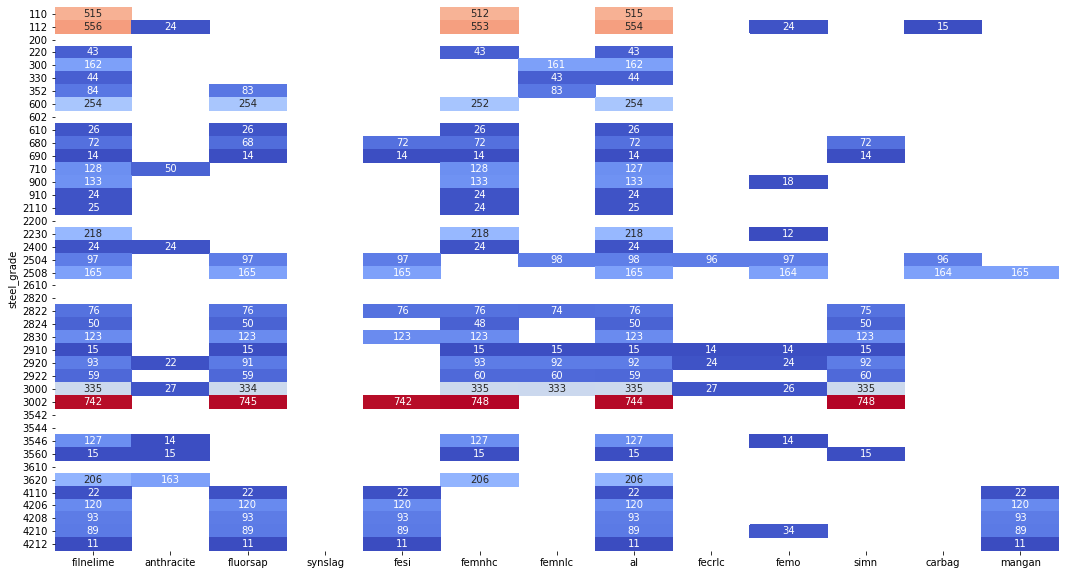

In [75]:
# Filter out steel grade = 200 for the visualization purpose

plt.figure(figsize = (18, 10))
_filter200 = _filter
_filter200.at[200, features_eaf_additions] = False
sns.heatmap(eaf_additions_cnt[_filter200],
            cmap = 'coolwarm', annot = True, fmt = 'g', cbar = False)
plt.show()

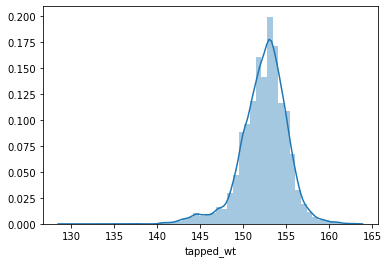

Average smetling weight at EAF: 152.43368072584636


In [76]:
# Consider the yield weight of the steel

_eaf_wt_mean = df_eaf['tapped_wt'].mean()
sns.distplot(df_eaf['tapped_wt'])
plt.show()
print(f'Average smetling weight at EAF: {_eaf_wt_mean}')

The yield wight of the steel is not constant, so the number of additives is appropriate to be converted into relative units (normalised on the total weight of the smelting).

In [77]:
# Additives, relative to the smelting mass

_df_eaf_rel = df_eaf[['steel_grade']].copy()
for col in features_eaf_additions:
    _df_eaf_rel[col] = (df_eaf[col]/df_eaf['tapped_wt']).copy()
    
eaf_additions_mean_rel = _df_eaf_rel.groupby('steel_grade')[features_eaf_additions].mean()
eaf_additions_std_rel = _df_eaf_rel.groupby('steel_grade')[features_eaf_additions].std()

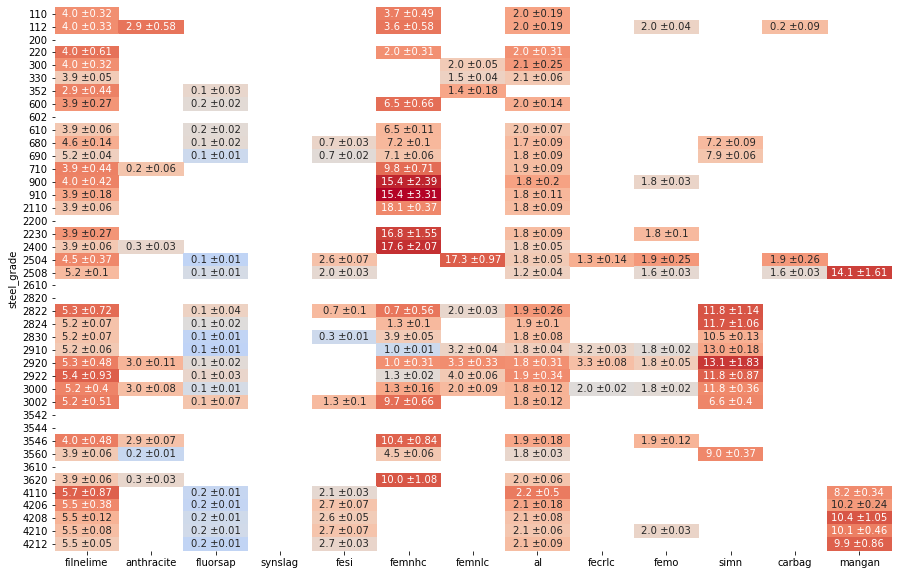

In [78]:
# Additives mean and std (%)

plt.figure(figsize=(15, 10))

# labeling
_labels = (eaf_additions_mean_rel.round(decimals=1).astype(str)+
           " ±" + eaf_additions_std_rel.round(decimals=2).astype(str))

sns.heatmap(np.log(eaf_additions_std_rel[_filter]),
            center=-4, cmap='coolwarm', annot=_labels, fmt='', cbar=False)
plt.show()

Main conclusions:
* `finelime` is consumed a lot (top-1); involved in the smelting of nearly every steel grade in average quantities
* `femnhc` is consumed a lot (top-2); involved in the smelting of many steels, in large quantities
* `al` consumed quite a lot in total (top-3); involved in the smelting of nearly every steel grade, in small quantities

### 3.3. Data analysis - LF

### 3.3.1. General additives statistics

In [79]:
# General additives statistics

df_lf[features_lf_additions].describe()

,fine_lime,anthracite,caf2,synslag,fesi,femnhc,femnlc,al,fecrlc,femo,simn,casiwire,alwire,fev,fet,fenb,carbag,mangan
count,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.000000,9377.0,9377.000000
mean,304.312360,9.456116,5.421350,9.828623,12.972699,77.721020,46.143329,36.838968,0.581956,1.350858,1.949984,14.301124,50.534678,3.507198,8.060254,19.029754,0.0,1.919910
std,118.706354,20.800158,29.347109,39.089179,35.793228,137.212105,130.161417,65.340622,6.747971,9.640895,46.367738,28.787157,37.298561,13.862016,16.487821,36.126137,0.0,19.809725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,230.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.513000,0.000000,0.000000,0.000000,0.0,0.000000
50%,287.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.820000,0.000000,0.000000,0.000000,0.0,0.000000
75%,351.000000,0.000000,0.000000,0.000000,0.000000,128.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,75.900000,0.000000,0.000000,14.000000,0.0,0.000000
max,1490.000000,237.000000,1777.000000,336.000000,545.000000,2769.000000,1908.000000,1124.000000,258.000000,333.000000,2217.000000,208.998000,410.520000,159.000000,97.000000,230.000000,0.0,681.000000


In [80]:
# The most common additives

df_lf[features_lf_additions].count()

fine_lime     9377
anthracite    9377
caf2          9377
synslag       9377
fesi          9377
femnhc        9377
femnlc        9377
al            9377
fecrlc        9377
femo          9377
simn          9377
casiwire      9377
alwire        9377
fev           9377
fet           9377
fenb          9377
carbag        9377
mangan        9377
dtype: int64

The data are not fully correct, if the additive is not present - zero is indicated, let us replace it with the missing values.

In [81]:
_tsts = df_lf.copy()
df_lf= df_lf.replace(0, np.nan)
df_lf[features_lf_additions].count()

fine_lime     9306
anthracite    2177
caf2          1519
synslag        807
fesi          1739
femnhc        4343
femnlc        2159
al            3291
fecrlc         105
femo           261
simn            38
casiwire      2065
alwire        7603
fev            719
fet           1864
fenb          2356
carbag           0
mangan         192
dtype: int64

The most common additives - `fine_lime`, `alwire` and `femnhc`.

In [82]:
# The most variable additives

df_lf[features_lf_additions].std() / df_lf[features_lf_additions].mean() 

fine_lime     0.378733
anthracite    0.596258
caf2          1.977614
synslag       0.669118
fesi          0.772954
femnhc        0.952243
femnlc        1.030817
al            0.674614
fecrlc        0.722179
femo          0.668670
simn          1.153322
casiwire      0.335386
alwire        0.502492
fev           0.524182
fet           0.174634
fenb          0.395882
carbag             NaN
mangan        1.098365
dtype: float64

The maximum variance have `simn`, `fecrlc` and `mangan`. 

In [83]:
# Frequency of steel grades smeltings
steel_grade_lf_cnt = df_lf.groupby('steel_grade').count()['heat_id'].sort_values(ascending=False)
steel_grade_lf_pct = (steel_grade_lf_cnt/steel_grade_lf_cnt.sum())

_thr = 0.01
active_steelgrades_cnt = steel_grade_lf_cnt[steel_grade_lf_pct>_thr].to_frame()
active_steelgrades = active_steelgrades_cnt.index.tolist()
 
print(f"Steel grades which appear more that in {_thr*100}% of all smetlings: {len(active_steelgrades)}")
active_steelgrades

Steel grades which appear more that in 1.0% of all smetlings: 17


[200,
 3002,
 112,
 110,
 3000,
 600,
 400,
 2230,
 3620,
 300,
 2508,
 900,
 2830,
 710,
 3546,
 2504,
 4206]

#### 3.3.2. Analysis of additives for steel grades

In [84]:
# Additive statistics depending of steel grade 

lf_additions_cnt = df_lf.groupby('steel_grade')[features_lf_additions].count()
lf_additions_mean = df_lf.groupby('steel_grade')[features_lf_additions].mean()
lf_additions_std = df_lf.groupby('steel_grade')[features_lf_additions].std()

In [85]:
# We consider only frequently used additives

_filter = lf_additions_cnt > 10

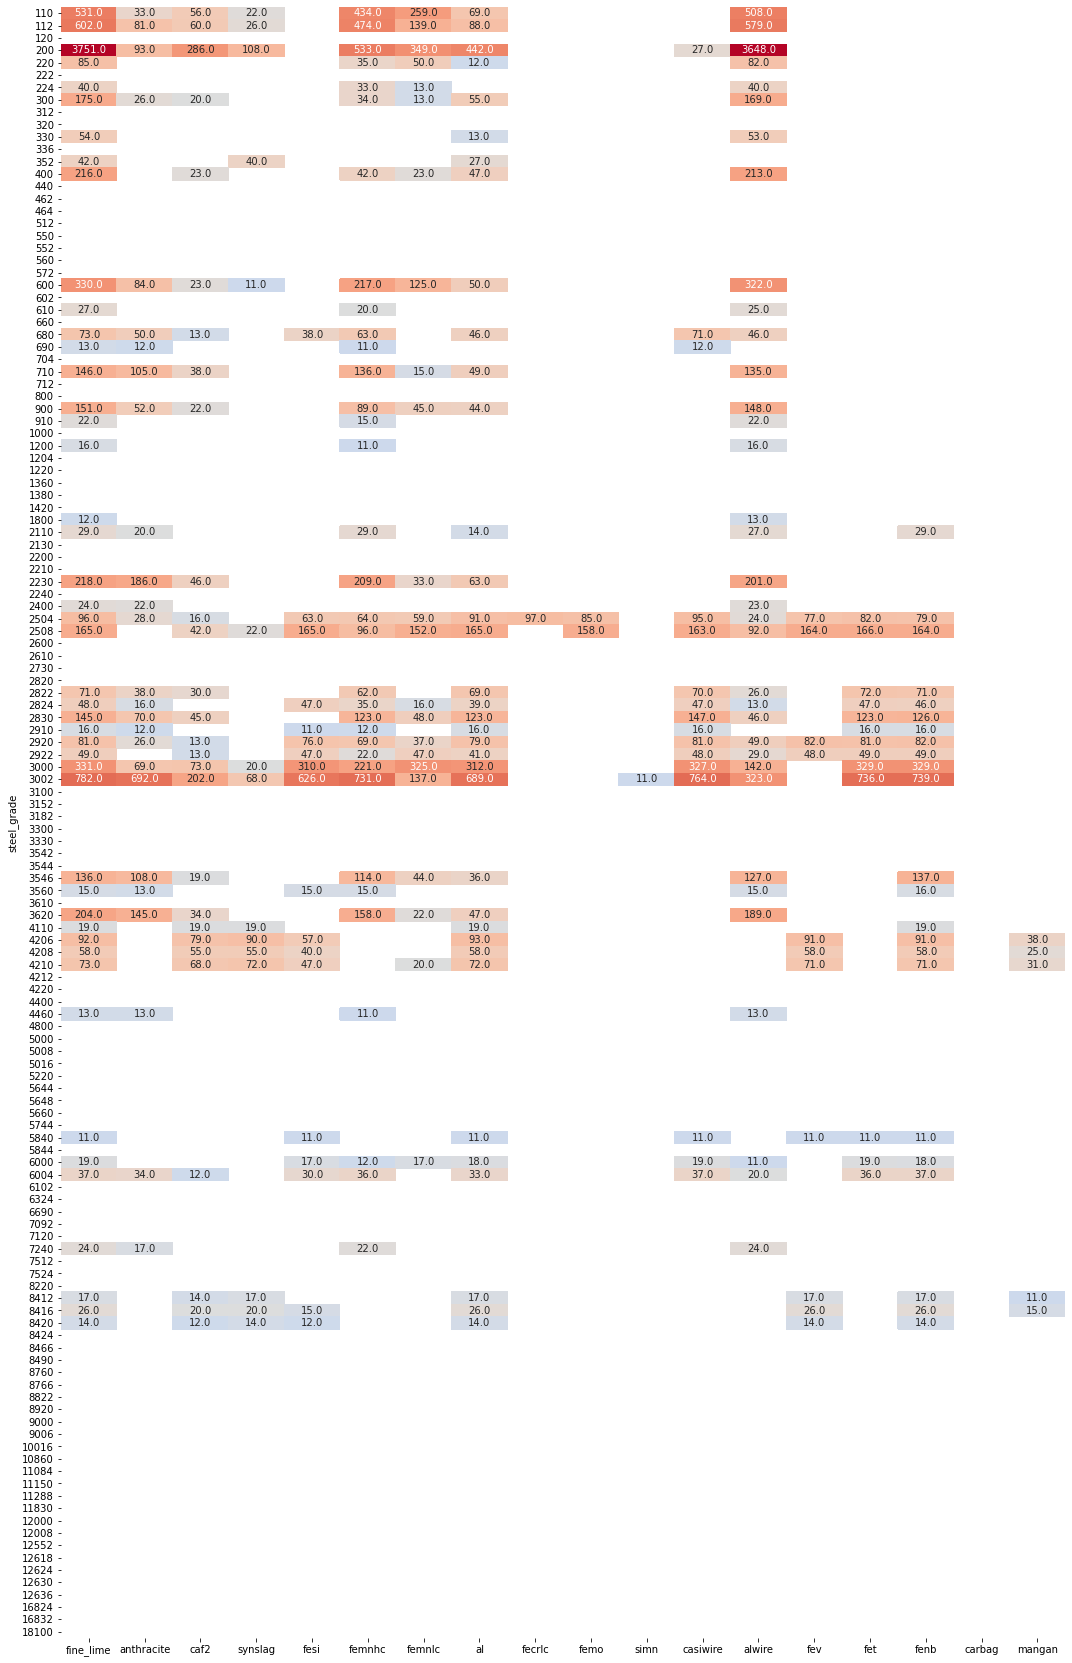

In [86]:
# How many times each additive were used for each steel grade?

plt.figure(figsize=(18, 30))
sns.heatmap(np.log(lf_additions_cnt[_filter]+1e-6),
            center=3, cmap='coolwarm', annot=lf_additions_cnt[_filter], fmt='', cbar=False)
plt.show()

The table is almost unreadable, we better use another way of visualization

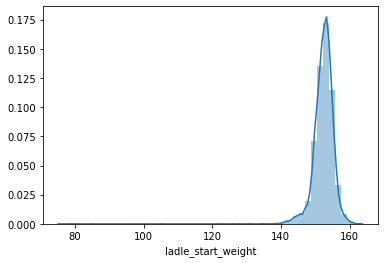

Average yield weight at LF stage: 152.3785883544843


In [87]:
# Stell weight distribution (from the CCM data)

_lf_wt_mean = df_lf['ladle_start_weight'].mean()
sns.distplot(df_lf['ladle_start_weight'].dropna())
plt.show()
print(f'Average yield weight at LF stage: {_lf_wt_mean}')

The steel yield weight, as well as in EAF, is not constant (although the variation is slightly less). Therefore, the number of additives is appropriate to be converted to relative units (normalised on the total smelting weight).

In [88]:
# Additives, relative to the smelting weight

_df_lf_rel = df_lf[['steel_grade']].copy()
for col in features_lf_additions:
    _df_lf_rel[col] = (df_lf[col]/df_lf['ladle_start_weight']).copy()
    
lf_additions_mean_rel = _df_lf_rel.groupby('steel_grade')[features_lf_additions].mean().loc[active_steelgrades]
lf_additions_std_rel = _df_lf_rel.groupby('steel_grade')[features_lf_additions].std().loc[active_steelgrades]

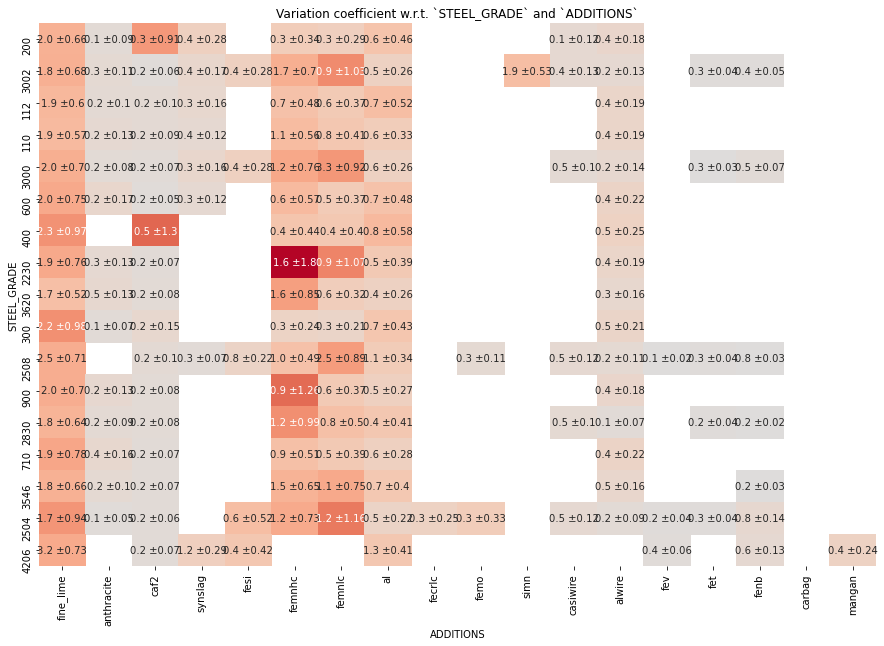

In [89]:
# Additives mean and std (%)

plt.figure(figsize=(15, 10))
plt.title("Variation coefficient w.r.t. `STEEL_GRADE` and `ADDITIONS`")

# labeling
_labels = (lf_additions_mean_rel.round(decimals=1).astype(str)+
           " ±" + lf_additions_std_rel.round(decimals=2).astype(str))

#sns.set(font_scale=0.8)
sns.heatmap(lf_additions_std_rel[_filter],
            center=0, cmap='coolwarm', annot=_labels, fmt='', cbar=False)
plt.xlabel('additions'.upper())
plt.ylabel('steel_grade'.upper())
plt.show()

## 3.4. Steel chemical composition analysis

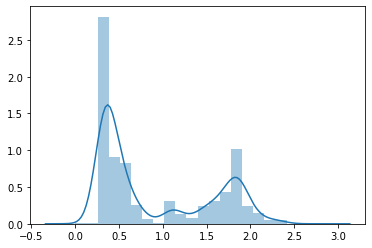

In [90]:
# total amount of all additives in the final product - EAF

sns.distplot(df_eaf_res[features_res_finalcomp].sum(1))
plt.show()

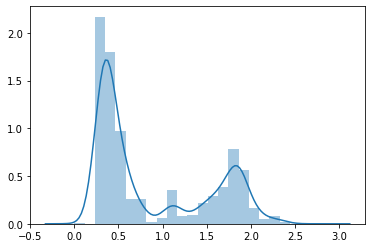

In [91]:
#  total amount of all additives in the final product - LF

sns.distplot(df_lf_res[features_res_finalcomp].sum(1))
plt.show()

It can be seen that we are dealing with low alloy steel.

In [92]:
# Does all steel have low alloy concentration?

df_lf.loc[df_lf[features_res_finalcomp].sum(1) > 2.5, features_res_finalcomp].shape[0]

0

#### 3.4.1. Chemical composition changes

In [93]:
# wrong way
# Has the total amount of components (chemical analysis) changed after LF 
#compared to the chemical analysis after EAF

_tmp = df_lf_res.merge(df_eaf_res, on=['heat_id', 'steel_grade'])

_tmp_nonsim_sum = (_tmp[_tmp[[f+'_x' for f in features_res_finalcomp]].sum(1) !=
                     _tmp[[f+'_y' for f in features_res_finalcomp]].sum(1)])

print(f"In {_tmp_nonsim_sum.shape[0]} observations from {_tmp.shape[0]}")

In 497 observations from 8190


In [94]:
# right way
# Let’s calculate how many observation has at least one component changed after LF (chemical analysis)


_tmp_nonsim = _tmp[(_tmp[[f+'_x' for f in features_res_finalcomp]].values !=
      _tmp[[f+'_y' for f in features_res_finalcomp]].values).any(1)]

print(f"In {_tmp_nonsim.shape[0]} observations from  {_tmp.shape[0]}")

In 3068 observations from  8190


Thus, only 35% of the component composition after LF differs from the component composition after EAF.

Let's analyze the changes.

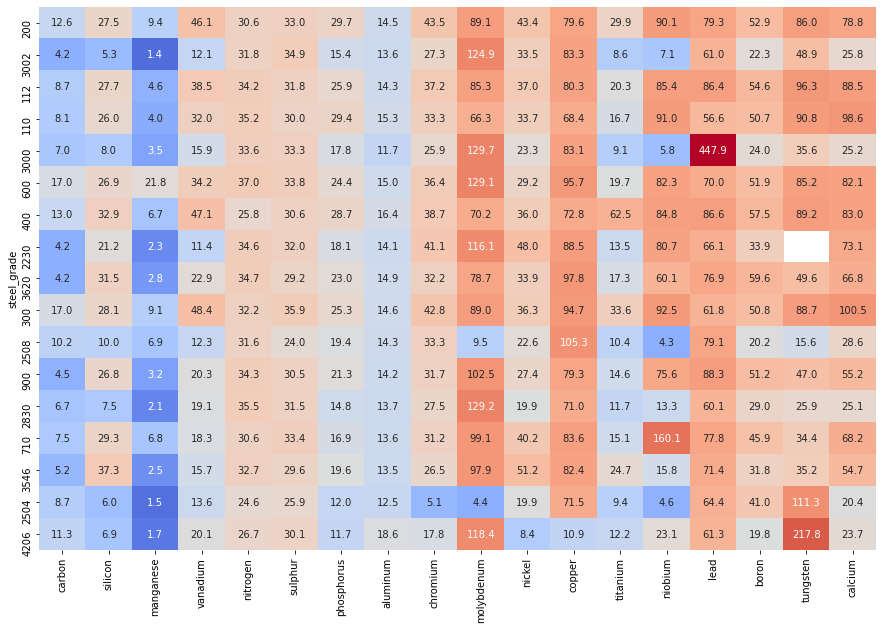

In [95]:
# Statistics for steel grades

lf_chem_mean = df_lf.groupby('steel_grade')[features_res_finalcomp].mean().loc[active_steelgrades]
lf_chem_std = df_lf.groupby('steel_grade')[features_res_finalcomp].std().loc[active_steelgrades]
lf_chem_varcoef = lf_chem_std/lf_chem_mean*100

# Variation coefficient visualization 

plt.figure(figsize=(15, 10))

_tmp = np.log(lf_chem_varcoef+1e-3)
sns.heatmap(_tmp,
            mask=np.logical_or(_tmp.isnull(), _tmp<0),# lf_chem_varcoef<10),
            annot=lf_chem_varcoef.round(1), fmt='',
            center=3, cmap='coolwarm', cbar=False)
plt.show()

#### 3.4.2. Additives analysis

In [96]:
# Possible additives

for i in sorted(set(features_lf_additions + features_eaf_additions)):
    print(i)

al
alwire
anthracite
caf2
carbag
casiwire
fecrlc
femnhc
femnlc
femo
fenb
fesi
fet
fev
filnelime
fine_lime
fluorsap
mangan
simn
synslag


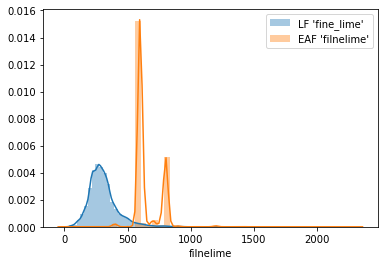

In [97]:
# filnelime & fine_lime can possibly differ but at the primary analytics purpose let us assume that they are same

sns.distplot(df_lf['fine_lime'].dropna())
sns.distplot(df_eaf['filnelime'].dropna())
plt.legend(["LF 'fine_lime'", "EAF 'filnelime'"])

plt.show()

## 3.5. Chemical composition limitations analysis

In [98]:
# Chemical composition limitations data
sheet_name = 'Sheet1'
df_limits = pd.read_pickle('../data/chemical_limits.sav')
print(f'{sheet_name} data shape: {df_limits.shape}')

Sheet1 data shape: (207, 18)


In [99]:
# For AIM steel grade should be presented
# Let us check if it presents for all observations

df_limits[df_limits['%']=='AIM'].steel_grade.isnull().sum()

0

In [100]:
# Add this steel grade to the rest cells (fix for bad excell format)

triplet = []

for idx in df_limits.index:
    row = df_limits.loc[idx]
    triplet.append(row)
    if len(triplet)==3:
        df_limits.loc[[r.name for r in triplet], 'steel_grade'] = triplet[1].steel_grade
        triplet = []

In [101]:
# check the format (min aim max)

(df_limits.groupby('steel_grade').count()['%'] != 3).sum()

0

In [102]:
# Fix steel grade type

df_limits['steel_grade'] = df_limits.steel_grade.astype(int)

In [103]:
df_limits.head()

,steel_grade,%,C,Si,Mn,P,S,Al,Cr,Ni,Mo,Cu,V,Nb,Ti,Sn,N,B
0,110,MIN,0.06,NaN,0.35,NaN,NaN,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110,AIM,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,110,MAX,0.08,0.03,0.45,0.02,0.015,0.060,0.1,0.15,0.02,0.15,0.008,0.006,0.008,0.015,0.008,0.0006
3,112,MIN,0.06,NaN,0.30,NaN,NaN,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112,AIM,0.07,NaN,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.6. Additives prices

In [104]:
# Table schema

df_prices = pd.read_csv('../data/additions_prices.csv', sep=';', index_col=0)
df_prices.head()

,price_lb,price_ub
addition,,
al,1000,1500
alwire,2100,3000
anthracite,200,300
caf2,400,400
carbag,4000,6000


In [105]:
# Add prices to the dataset

df_price_est_lb = df_lf.copy()
for col in features_lf_additions:
    df_price_est_lb[col] = df_lf[col] * df_prices.loc[col, 'price_lb'] / 1000

# Price statistics

price_additions_mean = df_price_est_lb.groupby('steel_grade')[features_lf_additions].mean().loc[active_steelgrades]
price_additions_std = df_price_est_lb.groupby('steel_grade')[features_lf_additions].std().loc[active_steelgrades]

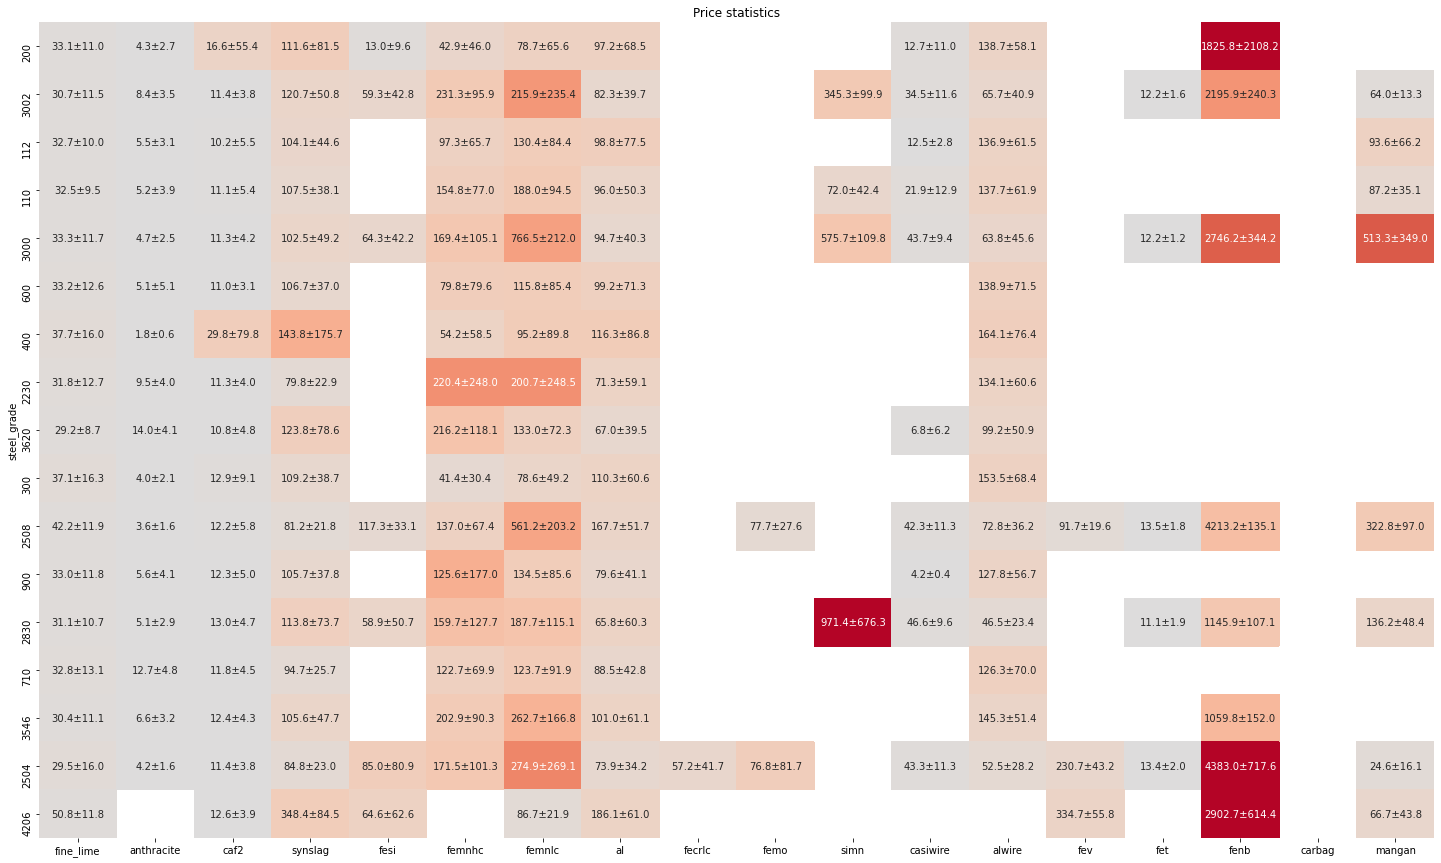

In [106]:
# Additives price mean and variation

plt.figure(figsize=(25, 15))
plt.title('Price statistics')

# labeling
_labels = (price_additions_mean.round(decimals=1).astype(str)+
           "±" + price_additions_std.round(decimals=1).astype(str))

sns.heatmap(price_additions_std,
            center=0, cmap='coolwarm', annot=_labels, fmt='', cbar=False, robust=True)
plt.show()

## 4. Steel grade 200 analysis

In [107]:
# Create temporary dataframe for analysis

_steel_grade = 200
_tmp = df_lf[df_lf.steel_grade == _steel_grade]

In [108]:
# Select steel grade 200

df_limits[df_limits.steel_grade == _steel_grade].fillna(0)

,steel_grade,%,C,Si,Mn,P,S,Al,Cr,Ni,Mo,Cu,V,Nb,Ti,Sn,N,B
9,200,MIN,0.04,0.00,0.15,0.00,0.00,0.025,0.00,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.0000
10,200,AIM,0.06,0.00,0.20,0.00,0.00,0.035,0.00,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.0000
11,200,MAX,0.07,0.03,0.25,0.02,0.02,0.060,0.08,0.12,0.015,0.11,0.008,0.005,0.01,0.015,0.007,0.0006


In [109]:
# Additives usage frequency
        
n = 5
_tmp_notnull_additions = (_tmp[features_lf_additions]>0).sum(0)

active_components_cnt = _tmp_notnull_additions[_tmp_notnull_additions>n]
active_components = active_components_cnt.index.tolist()
active_components_cnt.to_frame()

,0
fine_lime,3751
anthracite,93
caf2,286
synslag,108
femnhc,533
femnlc,349
al,442
casiwire,27
alwire,3648


In [110]:
# Normalize names of additives

_limits_naming_mapping = {'C': 'carbon',
                          'Si': 'silicon',
                          'Mn': 'manganese',
                          'P': 'phosphorus',
                          'S': 'sulphur',
                          'Al': 'aluminum',
                          'Cr': 'chromium',
                          'Ni': 'nickel',
                          'Mo': 'molybdenum',
                          'Cu': 'copper',
                          'V': 'vanadium',
                          'Nb': 'niobium',
                          'Ti': 'titanium',
                          'Sn': 'stannum',  # not in EAF/LF analysis
                          'N': 'nitrogen',
                          'B': 'boron',
                          'Pb': 'lead',
                          'W': 'tungsten',  # not in limits
                          'Ca': 'calcium'  # not in limits
                          }

df_limits.rename(columns=_limits_naming_mapping, inplace=True)
_features_res_finalcomp = set.intersection(set(features_res_finalcomp), set(df_limits.columns))

Additives distribution with the limits (where there are some).
* Red - lower limit
* Green - upper limit
* Black - target value

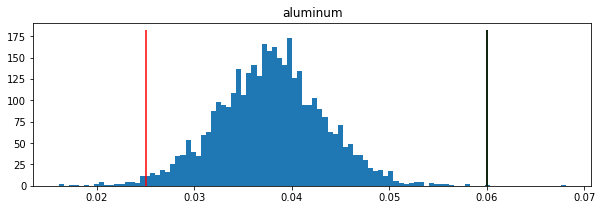

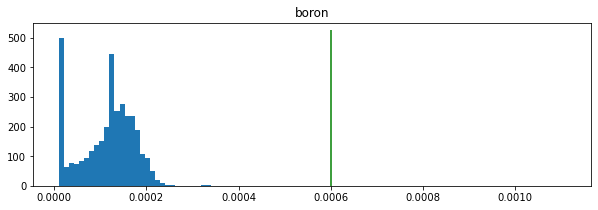

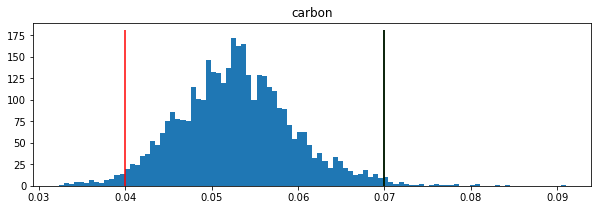

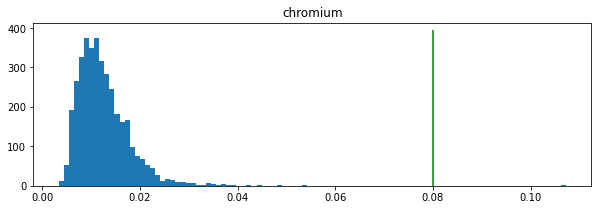

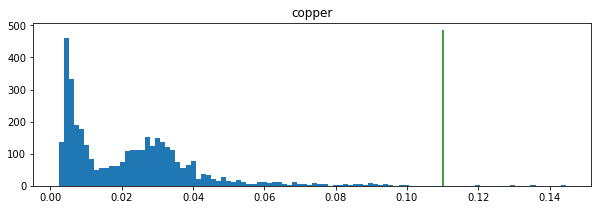

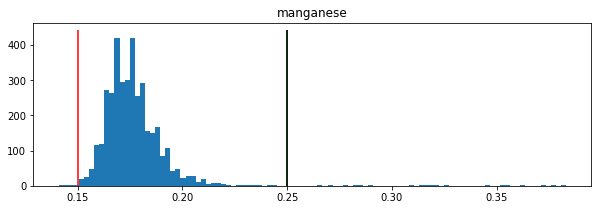

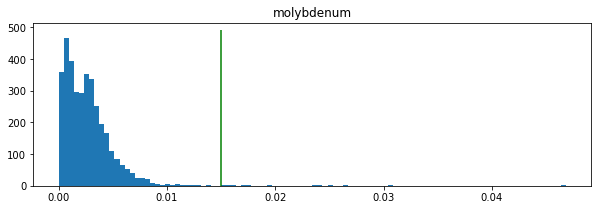

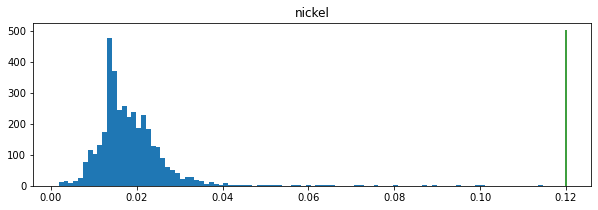

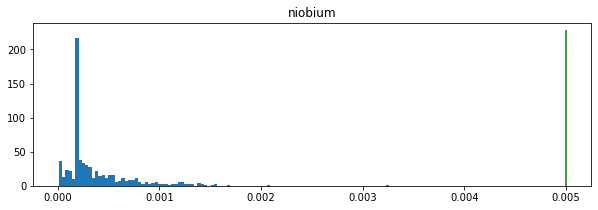

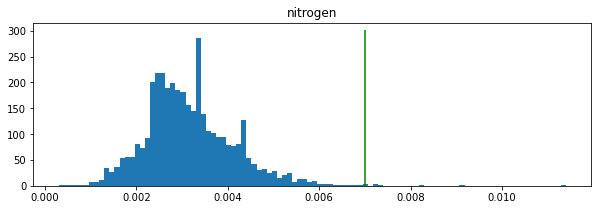

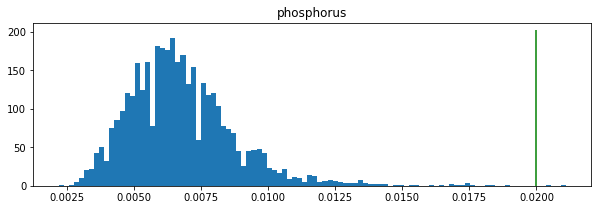

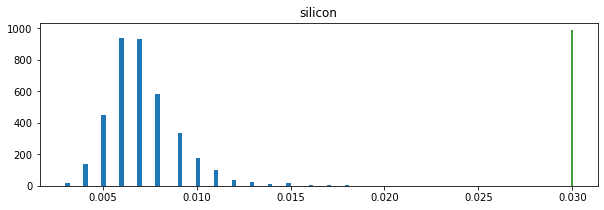

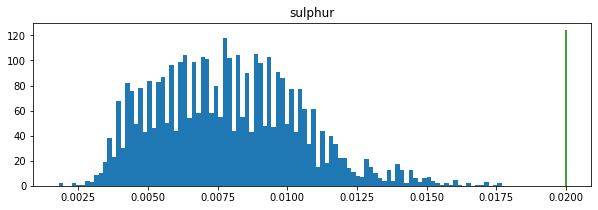

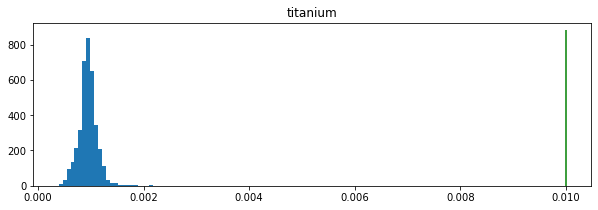

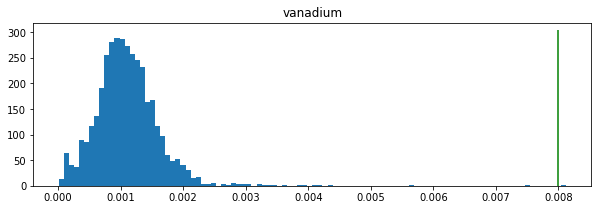

In [111]:
_has_lb = []
_has_ub = []

for comp in sorted(_features_res_finalcomp):
    
    try:
        plt.figure(figsize=(10, 3))
        plt.title(comp)
        ax = plt.axes()
        ax.hist(_tmp[comp], bins=100)
        _ylim_min, _ylim_max = ax.get_ylim()

        _min, _aim, _max = df_limits.loc[df_limits.steel_grade==_steel_grade, comp].values
        if not np.isnan(_min):
            plt.vlines(_min, 0, _ylim_max, color='red')
            _has_lb.append((comp, _min))
        if not np.isnan(_max):
            plt.vlines(_max, 0, _ylim_max, color='green')
            _has_ub.append((comp, _max))
        if not np.isnan(_aim):
            plt.vlines(_max, 0, _ylim_max, color='black')

        plt.show()
    except:
        pass

We can see that if lower limits are presented, there are recommended values. For components with an upper limit only, there are no recommended values.

In [112]:
# Defect share as a violation of limit values

for comp, lb in _has_lb:
    print(f'Below lb for {comp}: {(_tmp[comp]<lb).sum()/_tmp.shape[0]:.2%}')

Below lb for aluminum: 1.03%
Below lb for carbon: 1.91%
Below lb for manganese: 0.08%


In [113]:
# total defect share

_bools = []
for comp, lb in _has_lb:
    _bools.append(_tmp[comp]<lb)
_bools = pd.DataFrame(_bools).T
print(f'Total defect shape {_bools.any(1).sum()/_bools.shape[0]:.2%}')

Total defect shape 2.97%


In [114]:
# Potencial effect depending on the model error

model_err_percent = 0.1

_possible_optim = {}
for comp, lb in _has_lb:
    old_center = _tmp[comp].median()
    new_center = lb + old_center * model_err_percent
    new_center = old_center if (old_center - new_center) <= 0 else new_center
    economy = old_center - new_center
    _possible_optim[comp] = (lb, old_center, new_center, economy)
    print(f'{comp}: {economy:.2%}')

df_possible_optim = pd.DataFrame(
    _possible_optim, index=['lb', 'old_center', 'new_center', 'economy']).T
df_possible_optim

aluminum: 0.91%
carbon: 0.74%
manganese: 0.75%


,lb,old_center,new_center,economy
aluminum,0.025,0.0379,0.02879,0.00911
carbon,0.040,0.0527,0.04527,0.00743
manganese,0.150,0.1750,0.16750,0.00750


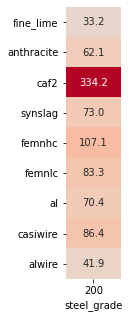

In [115]:
# Additives statisctics for steel_grade 200

_lf_chem_mean = _tmp.groupby('steel_grade')[features_lf_additions].mean()
_lf_chem_std = _tmp.groupby('steel_grade')[features_lf_additions].std()
_lf_chem_varcoef = _lf_chem_std/_lf_chem_mean*100

# Variation visualization

_plot_data = _lf_chem_varcoef[active_components].T
plt.figure(figsize=(1, 5))
sns.heatmap(_plot_data,
            annot=_plot_data.round(1), fmt='',
            center=3, cmap='coolwarm', cbar=False)
plt.show()

Correlation between additives and component weights

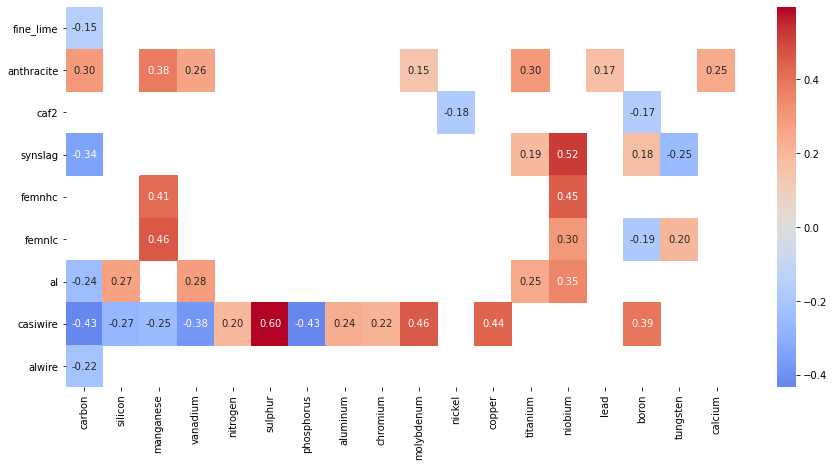

In [116]:
plt.figure(figsize=(15, 7))
R = _tmp.corr().loc[active_components, features_res_finalcomp]
sns.heatmap(R, mask=abs(R)<0.15, center=0, cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

Taking into account expert knowledge, there will be many questions.

# 5. Modeling

## 5.1. Dataset generation

In [117]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [118]:
# Combine all data into one dataframe

df_selected_steel = df_lf[df_lf.steel_grade == _steel_grade].copy()
df_selected_steel.shape

(3774, 58)

In [119]:
# Add EAF data

_tmp = (df_eaf[features_eaf_sys
               + features_eaf_additions
               + ['tapped_wt']
               + features_res_finalcomp]
        .rename(columns=lambda x: x+'_eaf' if x != 'heat_id' else x))
df_selected_steel = df_selected_steel.merge(_tmp,
                                            on=['heat_id'])
df_selected_steel.shape

(3118, 96)

In [120]:
# Chose the target - carbon (C)

_target = df_possible_optim.index[1]
_target

'carbon'

In [121]:
# We use as a features EAF additives, LF additive and smeltimg weight 

_descriptors = []

_descriptors += features_lf_additions
_descriptors += ['tapped_wt_eaf']
_descriptors += [col+'_eaf' for col in features_eaf_additions]

_descriptors

['fine_lime',
 'anthracite',
 'caf2',
 'synslag',
 'fesi',
 'femnhc',
 'femnlc',
 'al',
 'fecrlc',
 'femo',
 'simn',
 'casiwire',
 'alwire',
 'fev',
 'fet',
 'fenb',
 'carbag',
 'mangan',
 'tapped_wt_eaf',
 'filnelime_eaf',
 'anthracite_eaf',
 'fluorsap_eaf',
 'synslag_eaf',
 'fesi_eaf',
 'femnhc_eaf',
 'femnlc_eaf',
 'al_eaf',
 'fecrlc_eaf',
 'femo_eaf',
 'simn_eaf',
 'carbag_eaf',
 'mangan_eaf']

In [122]:
# Fill missing data with zero

df_selected_steel.fillna(0, inplace=True)

# Feature/target split
X = df_selected_steel[_descriptors]
y = df_selected_steel[_target]*100 # getting percents
X.shape, y.shape

((3118, 32), (3118,))

In [123]:
# Target statistics

y.mean(), y.std()

(5.2718345093008425, 0.6630941429017386)

In [124]:
# We can use standart CV if we consider smeltings independet 

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((2338, 32), (780, 32))

### 5.2. Random Forest

In [125]:
rf = RandomForestRegressor(n_estimators=300, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.18149182488230287

In [126]:
# MAE и MSE
(mean_absolute_error(y_test, rf.predict(X_test)),
 mean_squared_error(y_test, rf.predict(X_test)))

(0.46007608068438327, 0.349875298447779)

In [127]:
# Feature importance

df_wts = pd.DataFrame(rf.feature_importances_, index=_descriptors, columns=['w'])
df_wts.sort_values('w', ascending = False)

,w
alwire,0.205423
femnhc_eaf,0.141730
fine_lime,0.126293
tapped_wt_eaf,0.111717
al_eaf,0.110383
al,0.094412
filnelime_eaf,0.058571
femnlc,0.040731
femnhc,0.040634
anthracite,0.024901


### 5.3. Lasso regression

In [139]:
lm = Lasso(normalize = True, alpha = 1e-5)
lm.fit(X_train, y_train)
lm.score(X_test, y_test)

0.10109564120728276

In [140]:
# MAE и MSE
(mean_absolute_error(y_test, lm.predict(X_test)),
 mean_squared_error(y_test, rf.predict(X_test)))

(0.49318705966659965, 0.37467853983367877)

In [141]:
# Feature importances
df_wts = pd.DataFrame(lm.coef_, index=_descriptors, columns=['w'])
df_wts['abs_w'] = abs(df_wts.w)
df_wts.sort_values('abs_w')['w'].tail(10)

al_eaf       -0.003342
al           -0.003503
fesi_eaf     -0.004100
carbag_eaf   -0.004178
alwire       -0.005072
anthracite    0.005122
fesi         -0.007538
casiwire     -0.009690
simn          0.026663
fev           0.135960
Name: w, dtype: float64